### Set working directory

In [1]:
import os
WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-with-ml"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/thuang/Documents/Personal/code/microscopy-with-ml


### Read & Vis example image

In [2]:
from glob import glob

img_dir = "artifacts/data_ingestion/norm_images"
img_files = glob(f"{img_dir}/*.png")
print(f"Number of images: {len(img_files)}")

Number of images: 200


IDX: 172


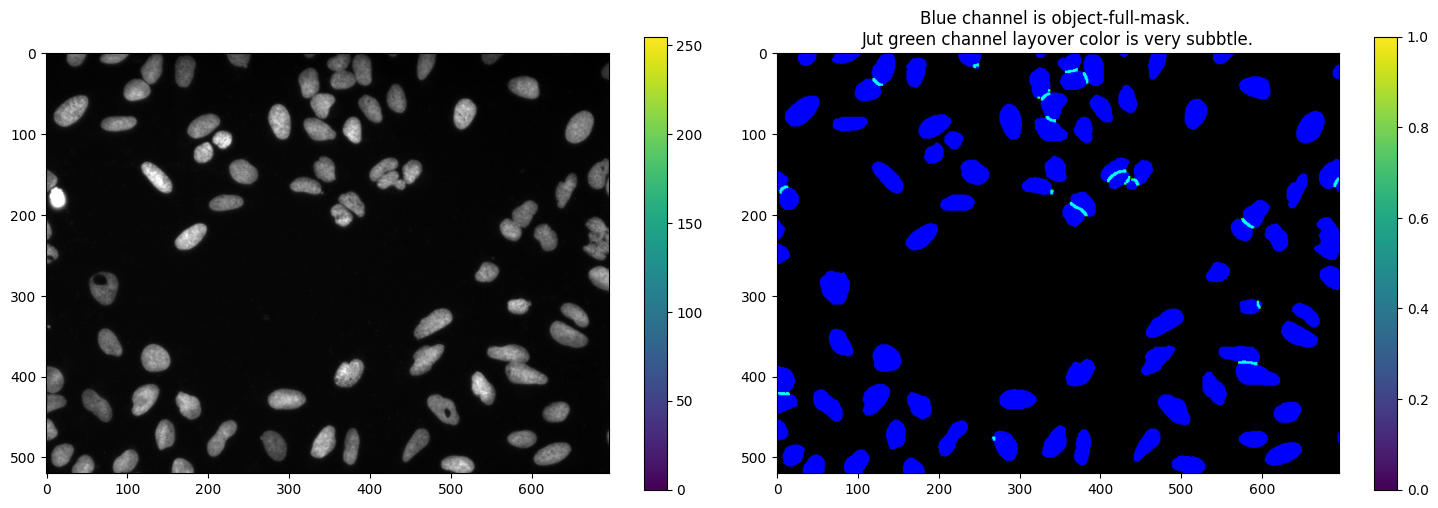

In [8]:
import random
import matplotlib.pyplot as plt
from mwm.components.image_processing import read_image_png, get_gt_mask_png

IDX = 172 # random.randint(0, len(img_files))
print(f"IDX: {IDX}")

img = read_image_png(img_files[IDX])

mask_dir = "artifacts/data_ingestion/masks"
mask_raw = read_image_png(os.path.join(mask_dir, os.path.basename(img_files[IDX])))
mask_png = get_gt_mask_png(mask_raw[:,:,0])
mask_gt = mask_png[:,:,1:] # leave out the 1st channel (empty), [0 1]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.colorbar(ax[0].imshow(img), ax=ax[0])
fig.colorbar(ax[1].imshow(mask_png), ax=ax[1])
ax[1].set_title("Blue channel is object-full-mask. \nJut green channel layover color is very subbtle.")
plt.tight_layout()
plt.show()

### Patch and unpatchify

In [35]:
import numpy as np
import math

def pad_image(image, patch_size, step):
    """
    Pads an image so it can be fully covered by patches, compatible with step (overlap).
    
    Args:
        image (np.ndarray): Input image, shape (H, W, C)
        patch_size (tuple): Patch size (h, w, c)
        step (int): Step size (stride) between patches

    Returns:
        padded_image (np.ndarray): Padded image
        pad_height (int): Total pixels padded at bottom
        pad_width (int): Total pixels padded at right
    """
    h, w, c = image.shape
    patch_h, patch_w, _ = patch_size

    # Calculate required padded dimensions
    n_steps_h = math.ceil((h - patch_h) / step) + 1
    n_steps_w = math.ceil((w - patch_w) / step) + 1

    target_h = step * (n_steps_h - 1) + patch_h
    target_w = step * (n_steps_w - 1) + patch_w

    pad_height = target_h - h
    pad_width = target_w - w

    # Apply padding
    padded_image = np.pad(
        image,
        ((0, pad_height), (0, pad_width), (0, 0)),
        mode='constant',
        constant_values=0
    )

    return padded_image

# padded_image, pad_height, pad_width = pad_image(img, patch_size, step)
# print(f"Image shape: {img.shape}")
# print(f"Total pixels padded at bottom: {pad_height}, Total pixels padded at right: {pad_width}")
# plt.imshow(padded_image)
# plt.show()

Patches shape: (3, 3, 1, 256, 256, 3)


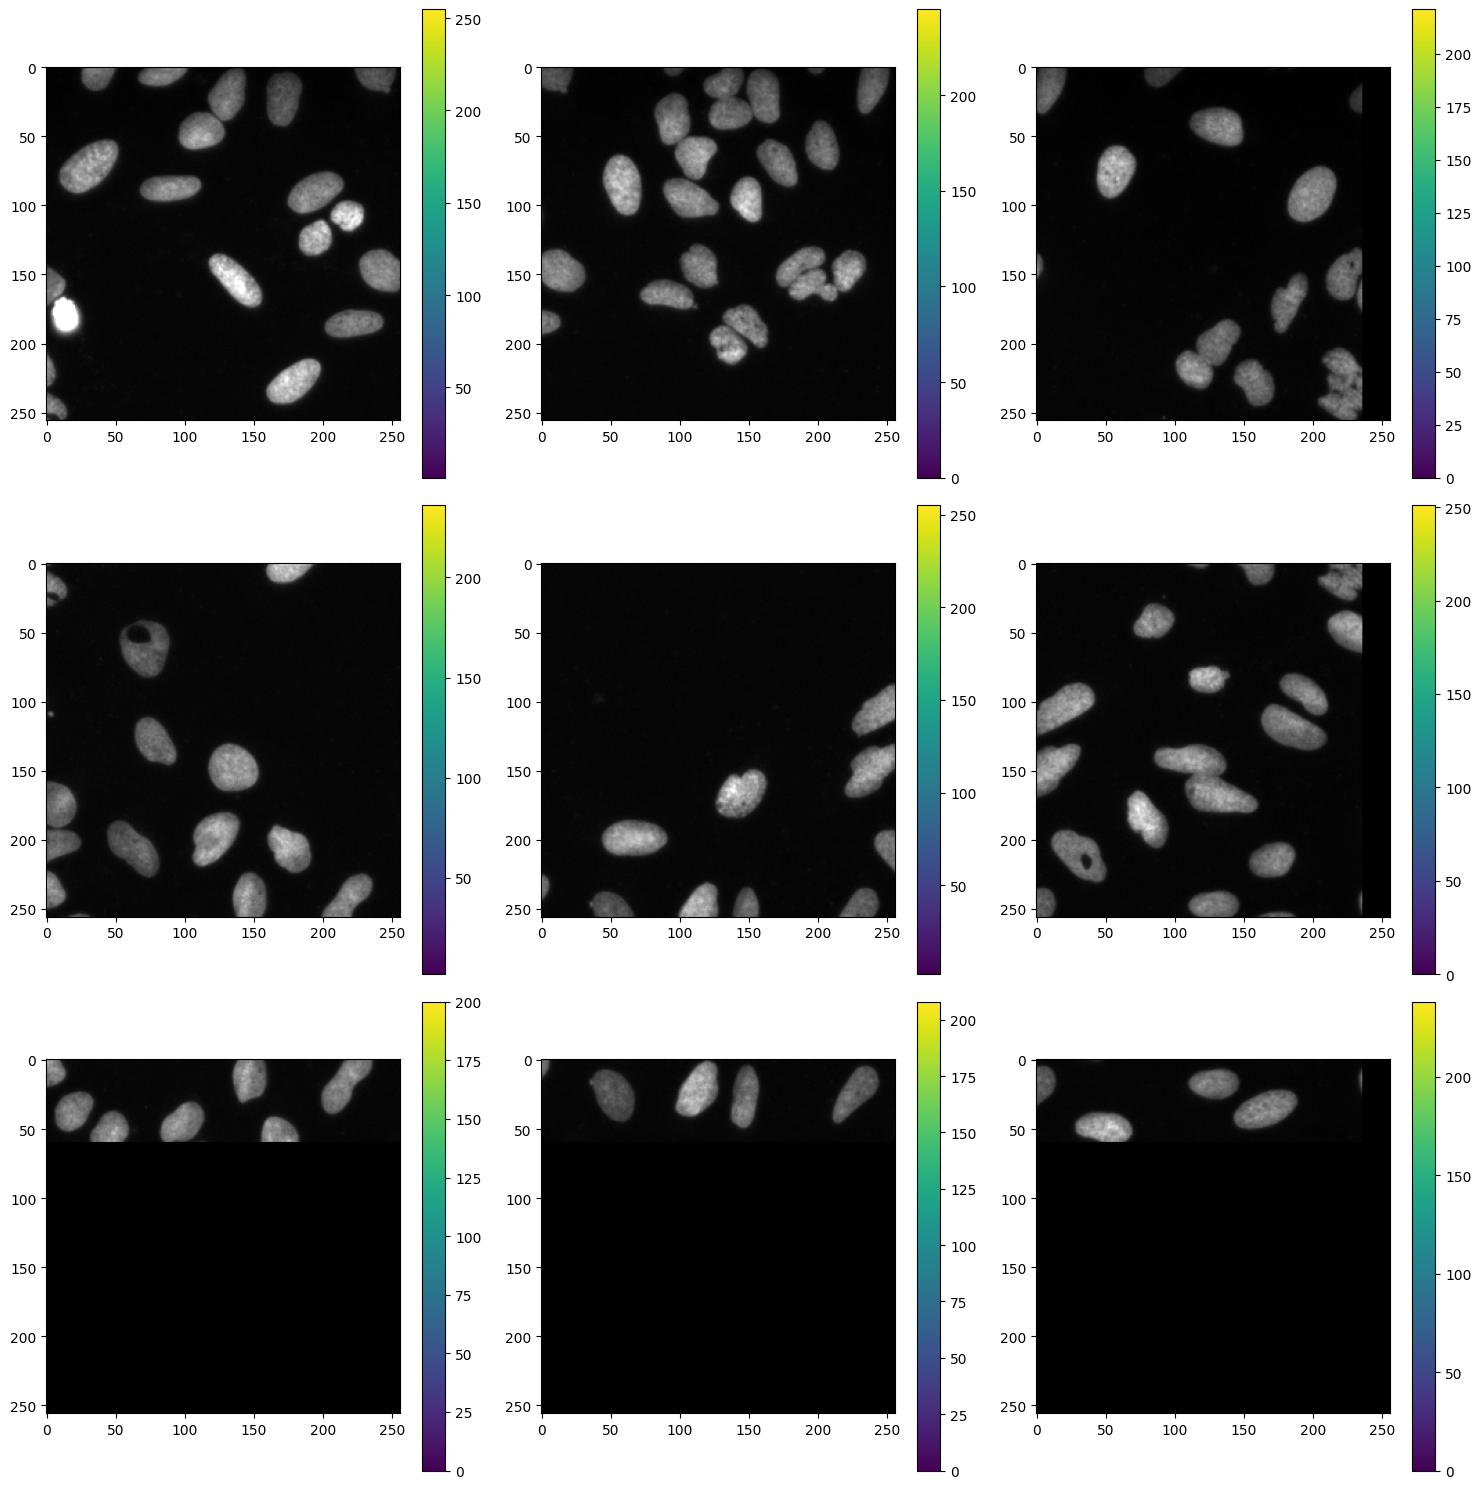

In [36]:
import numpy as np
from patchify import patchify

patch_size = (256, 256, 3)
step = 230 # 10% overlap

padded_image = pad_image(img, patch_size, step)

# Step 1: Extract overlapping patches
patches = patchify(padded_image, patch_size, step=step)
n_patches_h, n_patches_w = patches.shape[0], patches.shape[1]
print(f"Patches shape: {patches.shape}")

fig, ax = plt.subplots(n_patches_h, n_patches_w, figsize=(15, 15))
for i in range(n_patches_h):
    for j in range(n_patches_w):
        fig.colorbar(ax[i, j].imshow(patches[i, j].squeeze()))
plt.tight_layout()
plt.show()

Reconstructed image shape: (716, 716, 3)


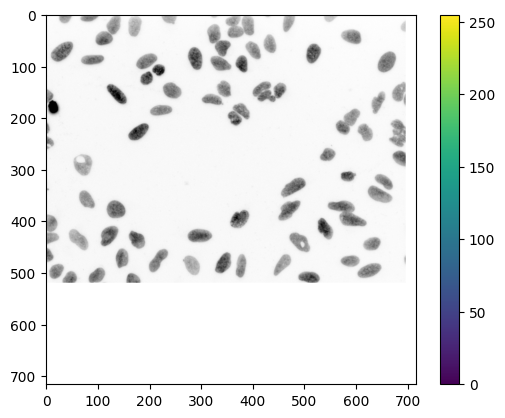

In [43]:
# Optional processing: dummy operation (multiply by 2)
processed_patches = (np.ones_like(patches) * 255. - patches).astype(np.float32)

# Step 2: Prepare reconstruction arrays
reconstructed = np.zeros_like(padded_image).astype(np.float32)
weight = np.zeros_like(padded_image)

# Step 3: Place patches and update weight mask
for i in range(n_patches_h):
    for j in range(n_patches_w):
        y = i * step
        x = j * step
        reconstructed[y:y+patch_size[0], x:x+patch_size[1], :] += processed_patches[i, j, 0]
        weight[y:y+patch_size[0], x:x+patch_size[1], :] += 1  # Increment weight mask

# Step 4: Avoid division by zero (just in case)
weight[weight == 0] = 1

# Step 5: Normalize
reconstructed /= weight.astype(np.float32)

print(f"Reconstructed image shape: {reconstructed.shape}")

# plt.imshow(processed_patches[0,0,:,:,:,:].squeeze().astype(np.uint8))
plt.imshow(reconstructed.astype(np.uint8))
plt.colorbar()
plt.show()

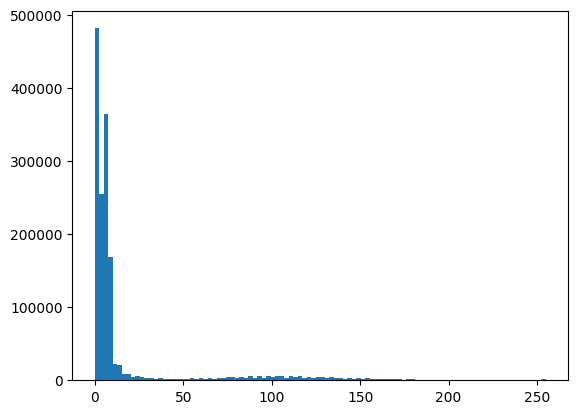

In [34]:
plt.hist(padded_image.flatten(), bins=100)
plt.show()

### Post-processing:
* Fill holes in nuclei:
  - e.g. IXMtest_N11_s4_w142A84EA3-47C3-4B49-B6CA-BBC6685BBE1E
* Thinning Ch0 (split-lines):
  - e.g.
  

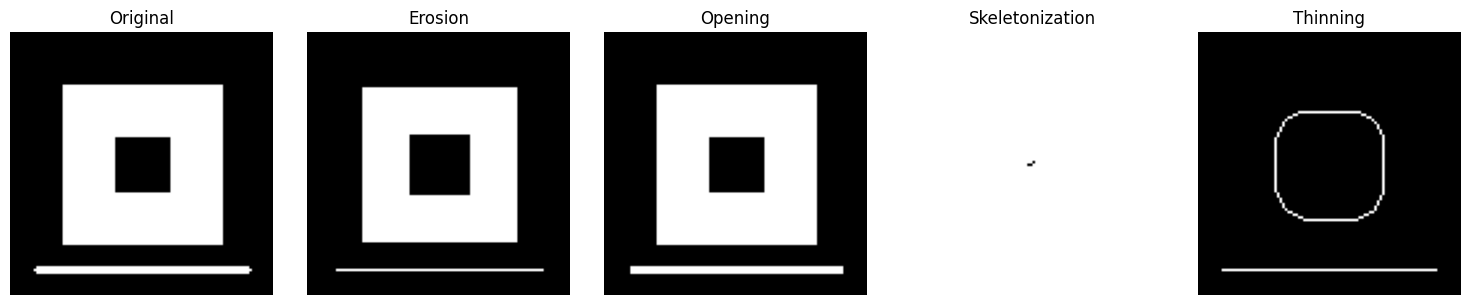

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, thin
from skimage.util import invert

# 1. Create a mock binary image (a white square with a hole and a line)
image = np.zeros((100, 100), dtype=np.uint8)
cv2.rectangle(image, (20, 20), (80, 80), 255, -1)          # Solid square
cv2.rectangle(image, (40, 40), (60, 60), 0, -1)            # Hole in the center
cv2.line(image, (10, 90), (90, 90), 255, 2)                # A horizontal line

# Structuring element
kernel = np.ones((3, 3), np.uint8)

# 2. Apply Erosion
eroded = cv2.erode(image, kernel, iterations=1)

# 3. Apply Opening (Erosion followed by Dilation)
opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

# 4. Skeletonization using skimage
# Convert to boolean for skeletonize, and invert (expects foreground=True)
skeleton = skeletonize(invert(image // 255))  # Convert 255 -> 1
skeleton = invert(skeleton) * 255  # Convert back to original orientation

# 5. Thinning using skimage
thinned = thin(image // 255) * 255  # Thin expects binary image

# 6. Plotting
titles = ['Original', 'Erosion', 'Opening', 'Skeletonization', 'Thinning']
images = [image, eroded, opened, skeleton.astype(np.uint8), thinned.astype(np.uint8)]

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


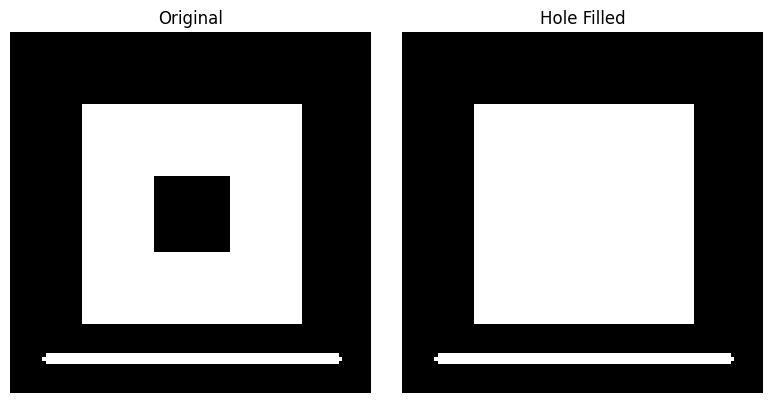

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

# 1. Recreate the same mock binary image
image = np.zeros((100, 100), dtype=np.uint8)
cv2.rectangle(image, (20, 20), (80, 80), 255, -1)          # Solid square
cv2.rectangle(image, (40, 40), (60, 60), 0, -1)            # Hole in the center
cv2.line(image, (10, 90), (90, 90), 255, 2)                # A horizontal line

# 2. Convert to boolean (skimage works with True/False)
binary_image = image > 0

# 3. Fill holes
filled = ndi.binary_fill_holes(binary_image)

# Optional: convert to uint8 for display
filled_uint8 = (filled * 255).astype(np.uint8)

# 4. Visualization
titles = ['Original', 'Hole Filled']
images = [image, filled_uint8]

plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


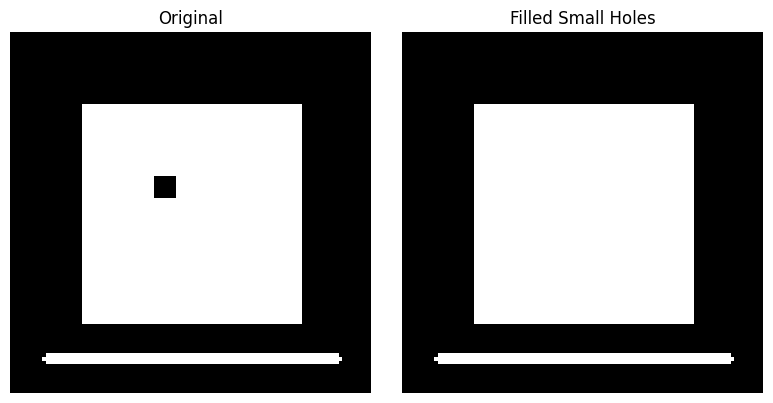

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_holes

# 1. Create the same mock binary image
image = np.zeros((100, 100), dtype=np.uint8)
cv2.rectangle(image, (20, 20), (80, 80), 255, -1)          # Solid square
cv2.rectangle(image, (40, 40), (45, 45), 0, -1)            # Hole in the center
cv2.line(image, (10, 90), (90, 90), 255, 2)                # A horizontal line

# 2. Convert to boolean
binary_image = image > 0

# 3. Fill holes smaller than a certain area
filled = remove_small_holes(binary_image, area_threshold=400, connectivity=2)

# 4. Convert back to uint8 for visualization
filled_uint8 = (filled * 255).astype(np.uint8)

# 5. Show original vs. filled
titles = ['Original', 'Filled Small Holes']
images = [image, filled_uint8]

plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


### Vis & Understand signed distance map (SDMs)

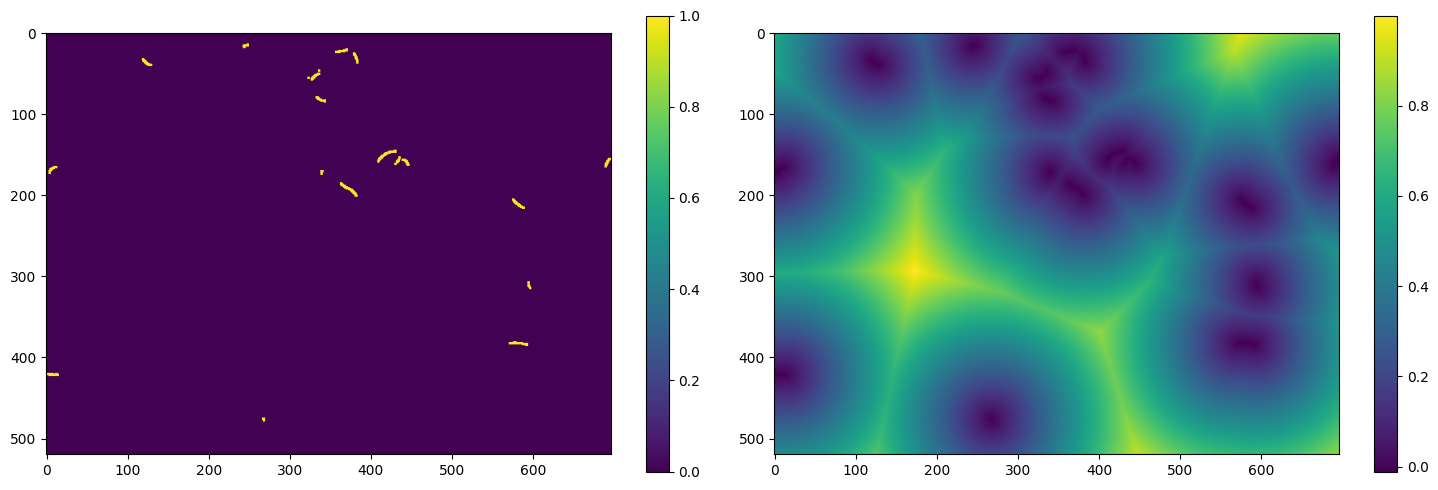

In [5]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def compute_sdm(mask):
    """
    Compute signed distance map (SDM) from boundary mask.
    Args:
        mask: Binary numpy array (H, W), 1 for boundary pixels, 0 elsewhere
    """
    posmask = mask.astype(bool)
    negmask = ~posmask
    sdm = distance_transform_edt(negmask) - distance_transform_edt(posmask)

    max_val = np.max(np.abs(sdm))
    sdm = sdm / (max_val + 1e-6) # Normalize to [-1, 1]

    return sdm

# Example usage
boundary_mask = mask_gt[:,:,0] # 1 for boundary pixels, 0 elsewhere
sdm = compute_sdm(boundary_mask)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.colorbar(ax[0].imshow(boundary_mask), ax=ax[0])
fig.colorbar(ax[1].imshow(sdm), ax=ax[1])
plt.tight_layout()
plt.show()

# Save SDM (float32)
# np.save('boundary_mask_sdm.npy', sdm)


### Pre-compute SDMs
 * Needed only for training set (but include val too in case we do cross-validation later)
 * Why not compute DT on the fly in loss function?
    1. Distance Transform (DT) is Non-Differentiable. So it blocks gradients → breaks learning.
    2. DT is CPU-based (non-PyTorch-native) → if done at runtime, you'd have:
        - CPU bottlenecks.
        - Frequent CPU-GPU data transfer (slow!). 

In [6]:
save_path = "artifacts/data_ingestion/sdms"

with open("artifacts/data_ingestion/metadata/training.txt", "r") as f:
    train_img_list = f.read().splitlines()
print(len(train_img_list))

with open("artifacts/data_ingestion/metadata/validation.txt", "r") as f:
    val_img_list = f.read().splitlines()
print(len(val_img_list))

img_list = train_img_list + val_img_list
print(len(img_list))

98
49
147


In [ ]:
# Pre-compute (one-off)

for filename in img_list:
    mask_raw = read_image_png(os.path.join(mask_dir, filename))
    mask_png = get_gt_mask_png(mask_raw[:,:,0])
    boundary_mask = mask_png[:,:,1]
    sdm = compute_sdm(boundary_mask)
    # np.save(os.path.join(save_path, filename.split(".")[0]), sdm.astype(np.float32))